
# Week 2 Lab — Data Cleaning, Feature Engineering, and Scaling (California Housing)

**Goal:** Practice end‑to‑end data preparation steps you saw in lecture: data exploration, cleaning missing values, feature engineering, normalization vs. standardization, categorical encoding, and pipelines.

**Deliverables (turn in this notebook):**
1. Completed code cells
2. Short answers in the **Reflection** section
3. RMSE values reported in plot titles where asked


## Setup and Download the data

In [2]:

# Install if needed (uncomment on your machine)
# %pip install -q scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [3]:

cal = fetch_california_housing()  # no as_frame in older sklearn
df = pd.DataFrame(cal.data, columns=cal.feature_names)
df["median_house_value"] = cal.target

df.rename(columns={
    "MedInc": "median_income",
    "HouseAge": "housing_median_age",
    "AveRooms": "avg_rooms_per_household",
    "AveBedrms": "avg_bedrooms_per_household",
    "AveOccup": "avg_occupants_per_household",
    "Latitude": "latitude",
    "Longitude": "longitude",
    "Population": "population",
}, inplace=True)


df["households"] = (df["population"] / df["avg_occupants_per_household"])
df["total_rooms"] = df["avg_rooms_per_household"] * df["households"]
df["total_bedrooms"] = df["avg_bedrooms_per_household"] * df["households"]
rng = np.random.default_rng(100)
mask = rng.choice([True, False], size=df.shape[0], p=[0.1, 0.9]) 
df.loc[mask, "total_bedrooms"] = np.nan


## Data Cleaning


We will use scikit-learn's **California Housing dataset** and build new columns to mirror the lecture:


- **Create a proxy categorical feature `ocean_proximity`** based on longitude:  
  - If longitude `< -122.5` → **"NEAR_OCEAN"**  
  - If `-122.5 ≤ longitude < -121.0` → **"NEAR_BAY"**  
  - If longitude `≥ -121.0` → **"INLAND"**
- Remove any rows with `NaN` values
- Check if any `NaNs` remain

In [ ]:


def prox_from_longitude(x):
    if x < -122.5:
        return "NEAR_OCEAN"
    elif -122.5 <= x < -121.0:
        return "NEAR_BAY"
    else:
        return "INLAND"


df["ocean_proximity"] = df["longitude"].apply(prox_from_longitude)

print(df.isna().sum())

df = df.dropna()  #removes any rows with NaN values
print(df.isna().sum())
df.head()


median_income                     0
housing_median_age                0
avg_rooms_per_household           0
avg_bedrooms_per_household        0
population                        0
avg_occupants_per_household       0
latitude                          0
longitude                         0
median_house_value                0
households                        0
total_rooms                       0
total_bedrooms                 2085
ocean_proximity                   0
dtype: int64
median_income                  0
housing_median_age             0
avg_rooms_per_household        0
avg_bedrooms_per_household     0
population                     0
avg_occupants_per_household    0
latitude                       0
longitude                      0
median_house_value             0
households                     0
total_rooms                    0
total_bedrooms                 0
ocean_proximity                0
dtype: int64


,median_income,housing_median_age,avg_rooms_per_household,avg_bedrooms_per_household,population,avg_occupants_per_household,latitude,longitude,median_house_value,households,total_rooms,total_bedrooms,ocean_proximity
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,126.0,880.0,129.0,NEAR_BAY
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1138.0,7099.0,1106.0,NEAR_BAY
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,177.0,1467.0,190.0,NEAR_BAY
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,259.0,1627.0,280.0,NEAR_BAY
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697,193.0,919.0,213.0,NEAR_BAY



3) Data exploration
Answer the questions inline after running the cells.
- How many rows/columns? 13 columns, 18555 rows
- Which columns have missing values? 0
- Are features numeric or categorical? Numeric


In [5]:

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18555 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   median_income                18555 non-null  float64
 1   housing_median_age           18555 non-null  float64
 2   avg_rooms_per_household      18555 non-null  float64
 3   avg_bedrooms_per_household   18555 non-null  float64
 4   population                   18555 non-null  float64
 5   avg_occupants_per_household  18555 non-null  float64
 6   latitude                     18555 non-null  float64
 7   longitude                    18555 non-null  float64
 8   median_house_value           18555 non-null  float64
 9   households                   18555 non-null  float64
 10  total_rooms                  18555 non-null  float64
 11  total_bedrooms               18555 non-null  float64
 12  ocean_proximity              18555 non-null  object 
dtypes: float64(12), objec

In [6]:

df.describe(include="all")


,median_income,housing_median_age,avg_rooms_per_household,avg_bedrooms_per_household,population,avg_occupants_per_household,latitude,longitude,median_house_value,households,total_rooms,total_bedrooms,ocean_proximity
count,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555.000000,18555
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INLAND
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12128
mean,3.870642,28.707949,5.424915,1.096136,1422.658583,3.058083,35.629983,-119.568721,2.071935,498.887039,2628.161412,536.939100,NaN
std,1.900920,12.595536,2.520732,0.485034,1129.974867,10.317869,2.136069,2.003819,1.155605,380.432333,2160.630800,419.184012,NaN
min,0.499900,1.000000,0.846154,0.444444,5.000000,0.970588,32.540000,-124.350000,0.149990,1.000000,6.000000,1.000000,NaN
25%,2.564700,18.000000,4.442145,1.006095,786.000000,2.428226,33.930000,-121.800000,1.198500,279.000000,1445.000000,295.000000,NaN
50%,3.534700,29.000000,5.224138,1.048622,1164.000000,2.817582,34.250000,-118.490000,1.800000,409.000000,2121.000000,434.000000,NaN
75%,4.740100,37.000000,6.047714,1.099462,1726.000000,3.282991,37.710000,-118.010000,2.652500,605.000000,3146.500000,647.000000,NaN



### Histograms of numeric features
Look for skew, outliers, and spread differences.


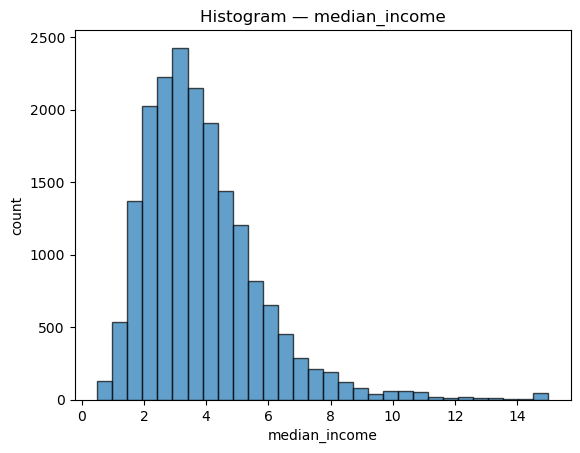

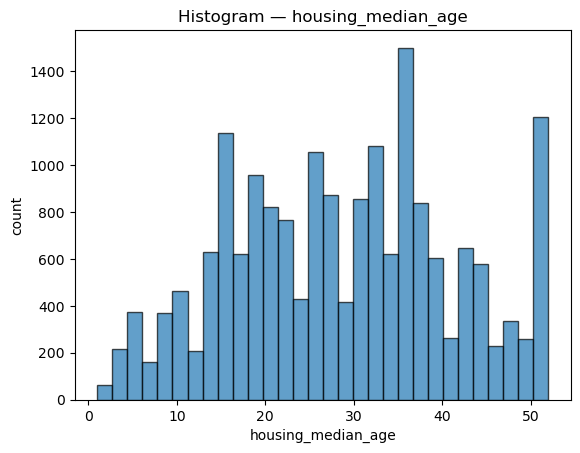

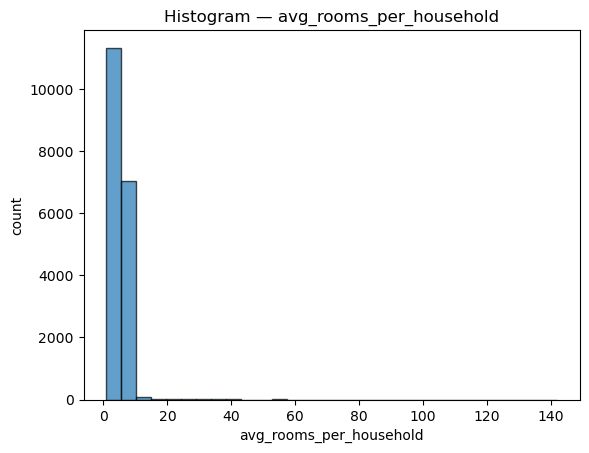

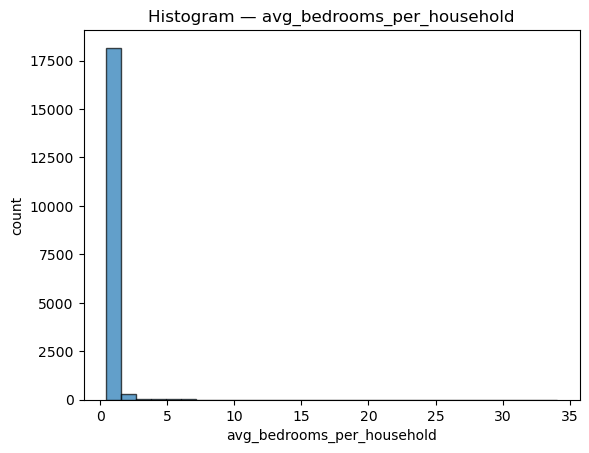

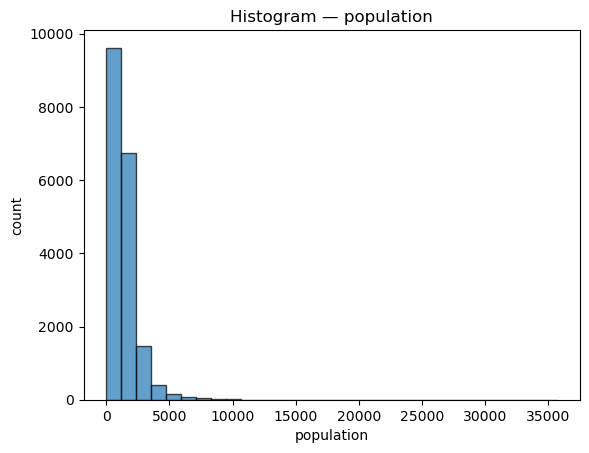

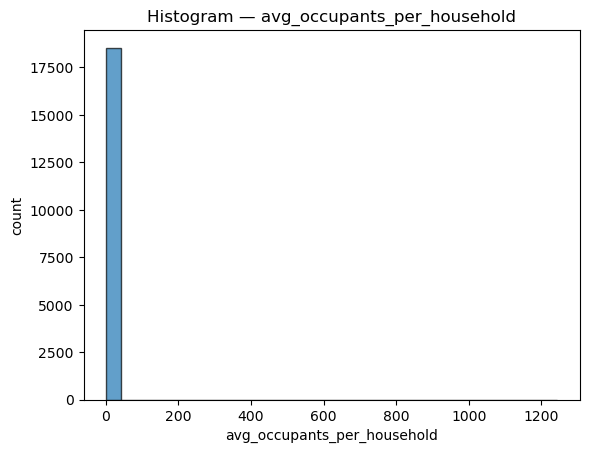

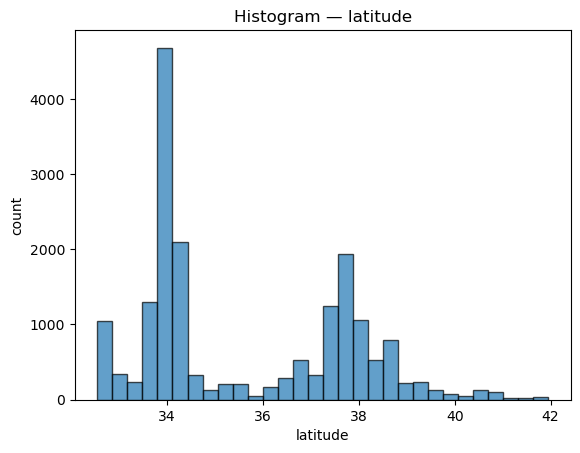

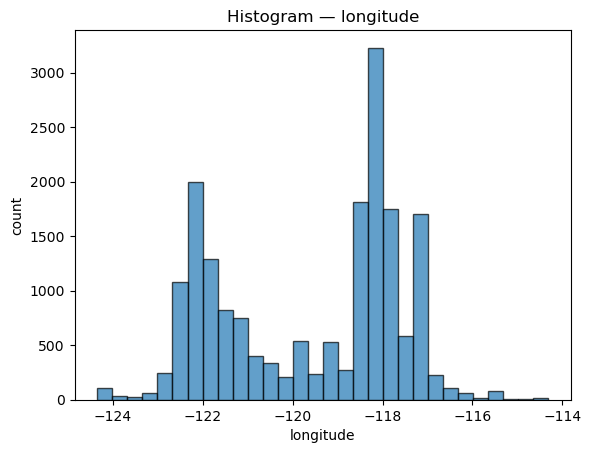

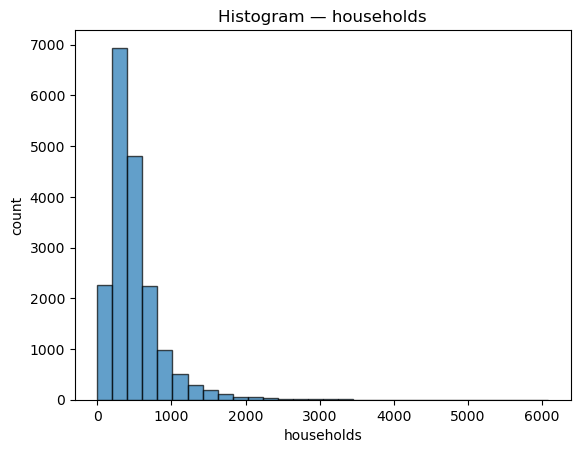

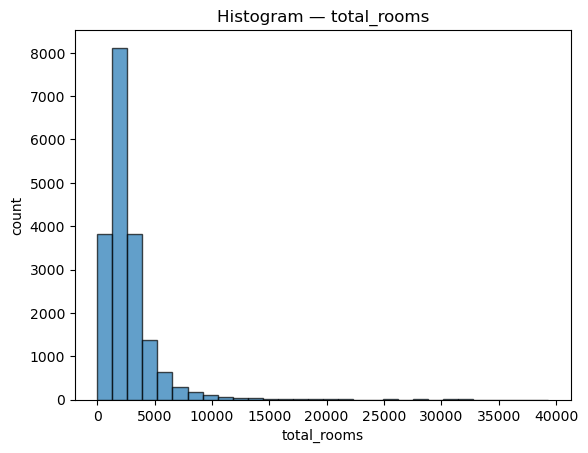

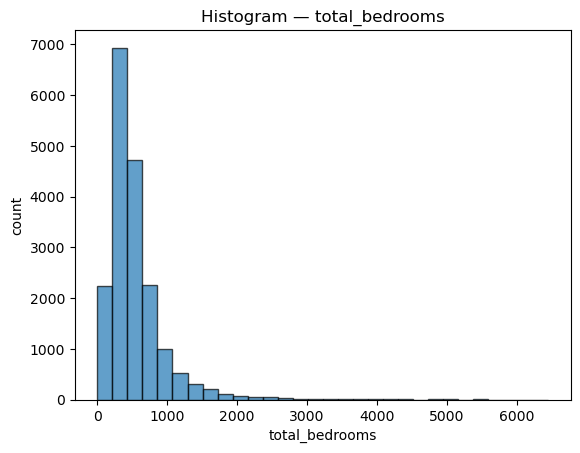

In [16]:

# Identify numeric columns (exclude categorical and target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('median_house_value')  # Remove target variable

for c in num_cols:
    plt.figure()
    plt.hist(df[c], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Histogram — {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()



### Scatter: `median_income` vs `median_house_value`


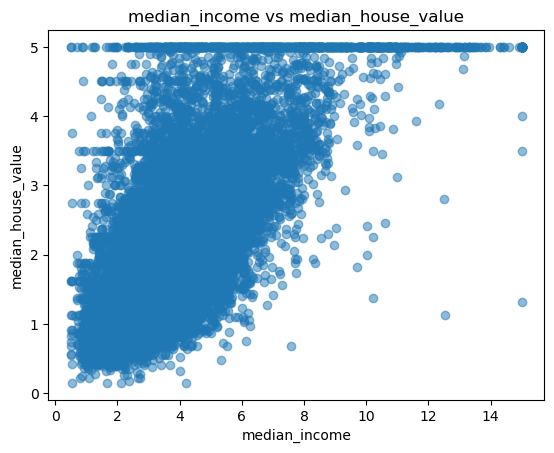

In [8]:

plt.figure()
plt.scatter(df["median_income"], df["median_house_value"], alpha=0.5)
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.title("median_income vs median_house_value")
plt.show()



## Feature engineering
Create `rooms_per_household = total_rooms / households`. Compare correlation with target vs. `total_rooms`.


In [ ]:

df_fe = df.copy()
df_fe["rooms_per_household"] = df_fe["total_rooms"] / df_fe["households"]

#comparing correlations with target
corr_total_rooms = df_fe["total_rooms"].corr(df_fe["median_house_value"])
corr_rph = df_fe["rooms_per_household"].corr(df_fe["median_house_value"])

print(f"Correlation of total_rooms with target: {corr_total_rooms:.4f}")
print(f"Correlation of rooms_per_household with target: {corr_rph:.4f}")
corr_total_rooms, corr_rph


Correlation of total_rooms with target: 0.1312
Correlation of rooms_per_household with target: 0.1524


(np.float64(0.1311540951949725), np.float64(0.1524156005145626))


## Normalization vs. Standardization (train/test kept separate)
Compare two pipelines: 
- Pipeline A: MinMaxScaler (normalization)
- Pipeline B: StandardScaler (standardization)



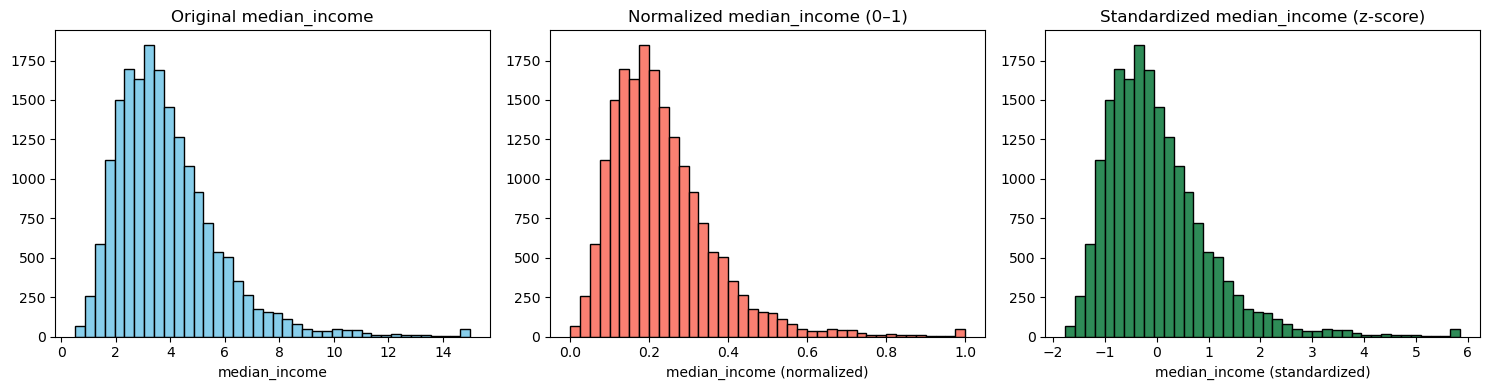

In [10]:

vals = df[["median_income"]] 
feature = "median_income"

# Normalization (0–1 scaling)
minmax_scaler = MinMaxScaler()
vals_norm = minmax_scaler.fit_transform(vals)

# Standardization (z-score)
std_scaler = StandardScaler()
vals_std = std_scaler.fit_transform(vals)


# Convert to 1D arrays for plotting
vals_1d = vals.values.ravel()
vals_norm_1d = vals_norm.ravel()
vals_std_1d = vals_std.ravel()

# Plot all three
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(vals_1d, bins=40, color="skyblue", edgecolor="k")
plt.title(f"Original {feature}")
plt.xlabel(feature)

plt.subplot(1,3,2)
plt.hist(vals_norm_1d, bins=40, color="salmon", edgecolor="k")
plt.title(f"Normalized {feature} (0–1)")
plt.xlabel(f"{feature} (normalized)")

plt.subplot(1,3,3)
plt.hist(vals_std_1d, bins=40, color="seagreen", edgecolor="k")
plt.title(f"Standardized {feature} (z-score)")
plt.xlabel(f"{feature} (standardized)")

plt.tight_layout()
plt.show()



## Categorical encoding 


1. **One-Hot Encode** the `ocean_proximity` column into binary indicator columns.  
2. Convert the one-hot matrix back into **integer labels** using `argmax`.  

This will help you understand the difference between one-hot vectors (for ML algorithms) and integer encodings (for compact representation).



In [17]:
from sklearn.preprocessing import OneHotEncoder

# Select the categorical column
cat_col = "ocean_proximity"

# One-hot encode the categorical column
encoder = OneHotEncoder(sparse_output=False)
ohe = encoder.fit_transform(df[[cat_col]])

print("One-hot encoded shape:", ohe.shape)
print("Categories:", encoder.categories_)

pd.DataFrame(ohe[:5])


One-hot encoded shape: (18555, 3)
Categories: [array(['INLAND', 'NEAR_BAY', 'NEAR_OCEAN'], dtype=object)]


,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [ ]:
labels = np.argmax(ohe, axis=1)
print(labels)

[1 1 1 ... 1 1 1]


## Train, Validation, and Test Split

Now that we have a clean dataset, we need to split it into three parts:

**Training set (≈ 70%)** → used to fit the model  
**Validation set (≈ 15%)** → used for tuning hyperparameters and checking overfitting  
**Test set (≈ 15%)** → kept separate until the very end to measure generalization  


- Split the dataset into `train`, `validation`, and `test`.  
- Check the shapes of each set to confirm the split ratios.  
- Print the first few rows of each split.


In [13]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=["median_house_value"])
y = df["median_house_value"]

# First split: train vs temp (validation+test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: validation vs test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)




Train set shape: (12988, 12) (12988,)
Validation set shape: (2783, 12) (2783,)
Test set shape: (2784, 12) (2784,)
